# Курсовой проект для курса "Python для Data Science"
## Построение модели для предсказания цен на недвижимость (квартиры)

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

### Подключение библиотек и скриптов

In [2331]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, GridSearchCV

%matplotlib inline

#### Функция отображения диаграммы разброса

In [2332]:
def show_scatter(df, x, y):
    plt.figure(figsize=(16, 8))
    plt.scatter(df[x], df[y])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title('Distribution of ' + x + ' by ' + y)
    plt.show()

In [2333]:
def show_scatter_price(df, y):
    show_scatter(df, 'Price', y)

#### Функция получения медианы и моды

In [2334]:
def get_median_mode(df, field):
    med = df[field].median()
    mod = df[field].mode()[0]
    print("median = {}, mode = {}".format(med, mod))
    return (med, mod)

#### Функция получения моды в разрезе районов

In [2335]:
def get_district_mode(df, field):
    return df.groupby(['DistrictId'], as_index=False).agg({field: lambda x: x.mode()[0]}).\
            set_index('DistrictId')[field].to_dict()

#### Функция получения медианы в разрезе районов

In [2336]:
def get_district_median(df, field):
    return df.groupby(['DistrictId'], as_index=False).agg({field:'median'}).\
            set_index('DistrictId')[field].to_dict()

#### Функция отображения графика предсказания

In [2337]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2_score(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

In [2338]:
def evaluate_preds2(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2_score(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2_score(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Пути к директориям и файлам

In [2339]:
PATH_TEST_DS = 'test.csv'
PATH_TRAIN_DS = 'train.csv'

### Загрузка данных

In [2340]:
df = pd.read_csv(PATH_TRAIN_DS)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [2341]:
df_test = pd.read_csv(PATH_TEST_DS)
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


### Количество и типы данных

In [2342]:
df.shape

(10000, 20)

In [2343]:
df_test.shape

(5000, 19)

In [2344]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [2345]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       3959 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 742.3+ KB


Обращаем внимание что есть номинативные признаки и признаки с пропусками

### Приведение типов данных

In [2346]:
df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

Приведём идентификаторы к строковому типу

In [2347]:
df['Id'] = df['Id'].astype(str)
df['DistrictId'] = df['DistrictId'].astype(str)

In [2348]:
df_test['Id'] = df_test['Id'].astype(str)
df_test['DistrictId'] = df_test['DistrictId'].astype(str)

### Анализ целевой переменной

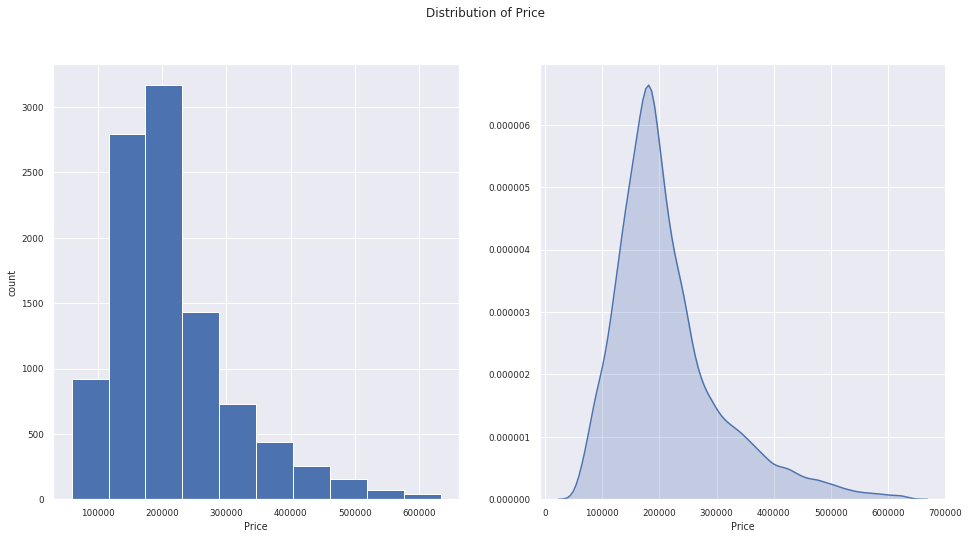

In [2349]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
df['Price'].hist()
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(df['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of Price')
plt.show()

In [2350]:
target_mean = df['Price'].mean()
target_median = df['Price'].median()
target_mode = df['Price'].mode()[0]

target_mean, target_median, target_mode

(214138.85739873844, 192269.64487934904, 59174.77802758122)

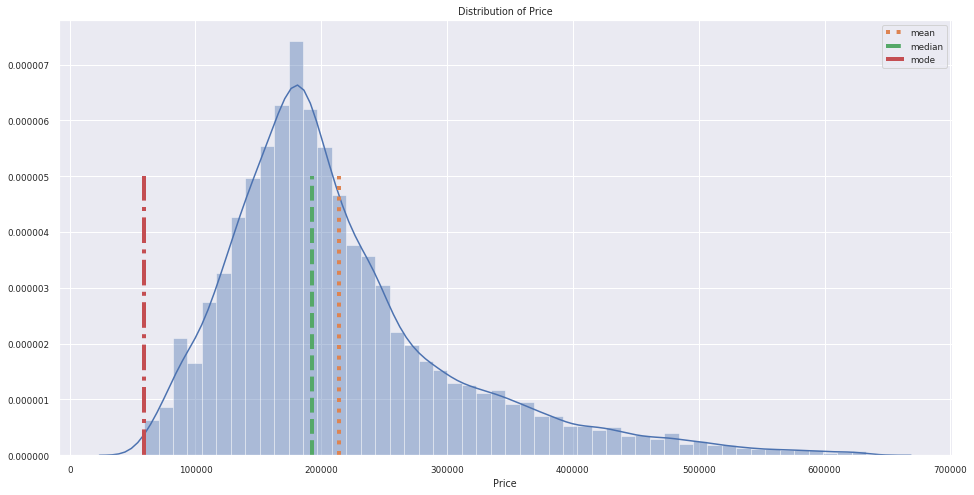

In [2351]:
plt.figure(figsize = (16, 8))

sns.distplot(df['Price'])

y = np.linspace(0, 0.000005, 100)
plt.plot([target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 100, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

### Обзор количественных переменных

In [2352]:
df_num_features = df.select_dtypes(include=['float64', 'int64'])
df_num_features.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,NaN,0,11,184966.930730
1,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16,300009.450063
2,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3,220925.908524
3,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5,175616.227217
4,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4,150226.531644


In [2353]:
df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Обзор номинативных переменных

In [2354]:
df_obj_features = df.select_dtypes(include='object')
df_obj_features.head()

,Id,DistrictId,Ecology_2,Ecology_3,Shops_2
0,14038,35,B,B,B
1,15053,41,B,B,B
2,4765,53,B,B,B
3,5809,58,B,B,B
4,10783,99,B,B,B


In [2355]:
df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [2356]:
df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [2357]:
df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [2358]:
df['DistrictId'].value_counts().head()

/home/roman/anaconda3/lib/python3.7/site-packages/IPython/core/displayhook.py:276: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  'Flushing oldest {cull_count} entries.'.format(sz=sz, cull_count=cull_count))


27    851
1     652
23    565
6     511
9     294
Name: DistrictId, dtype: int64

In [2359]:
df['DistrictId'].value_counts().tail()

205    1
209    1
117    1
207    1
199    1
Name: DistrictId, dtype: int64

Пустых или ошибочных значений нет

### Обзор пропусков

In [2360]:
len(df) - df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [2361]:
len(df_test) - df_test.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

### Обработка выбросов

In [2362]:
df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### Rooms

In [2363]:
field = 'Rooms'

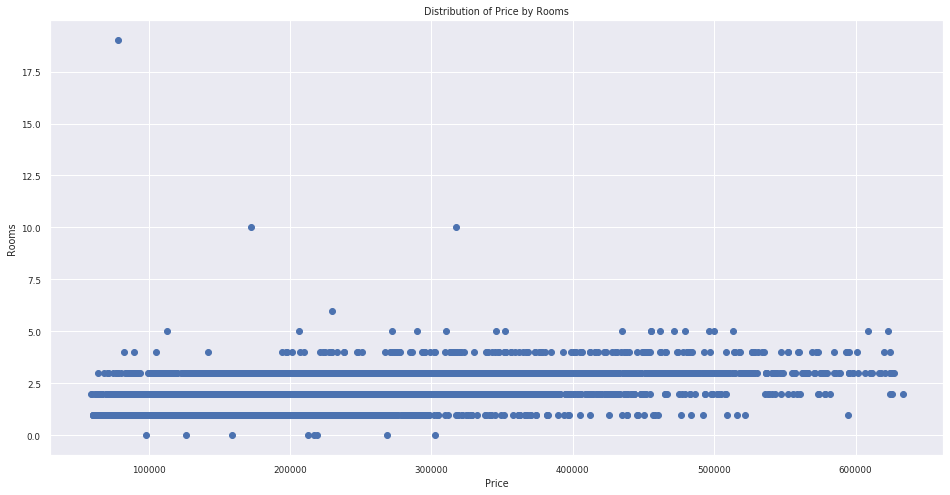

In [2364]:
show_scatter_price(df, field)

In [2365]:
df.sort_values([field], ascending=False)[field].head()

1454    19.0
377     10.0
8849    10.0
2170     6.0
8726     5.0
Name: Rooms, dtype: float64

In [2366]:
df.sort_values([field], ascending=True)[field].head()

3911    0.0
4853    0.0
8834    0.0
1981    0.0
6149    0.0
Name: Rooms, dtype: float64

Вычисляем моду для каждого района и заменяем ей значения больше либо равные 10, если для района значение не найдено, то заменяем на моду по всей выборке

In [2367]:
df_true = df[field]<=10
df_false = df[field]>10

med, mod = get_median_mode(df[df_true], field)

gr = get_district_mode(df[df_true], field)
list(gr.items())[:10]

median = 2.0, mode = 2.0


[('0', 1.0),
 ('1', 2.0),
 ('10', 2.0),
 ('100', 2.0),
 ('101', 2.0),
 ('102', 2.0),
 ('103', 2.0),
 ('104', 2.0),
 ('105', 2.0),
 ('106', 3.0)]

In [2368]:
df.loc[df_false, field] = df.loc[df_false, ['DistrictId', field]].apply(
    lambda x: [x['DistrictId'], gr.get(x['DistrictId'], mod)], axis=1, result_type='broadcast')[field]

df_true = df_test[field]<=10
df_false = df_test[field]>10

df_test.loc[df_false, field] = df_test.loc[df_false, ['DistrictId', field]].apply(
    lambda x: [x['DistrictId'], gr.get(x['DistrictId'], mod)], axis=1, result_type='broadcast')[field]

df[field] = df[field].astype(float)
df_test[field] = df_test[field].astype(float)

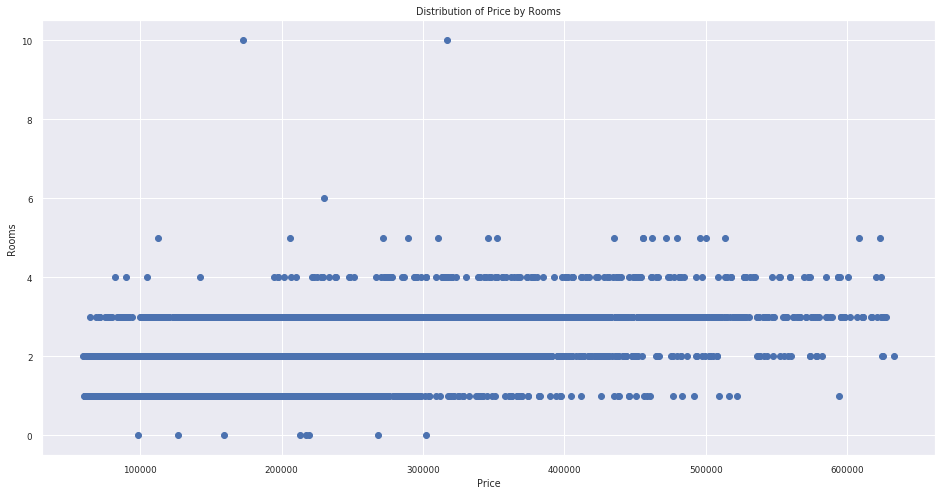

In [2369]:
show_scatter_price(df, field)

#### Square

In [2370]:
field = 'Square'

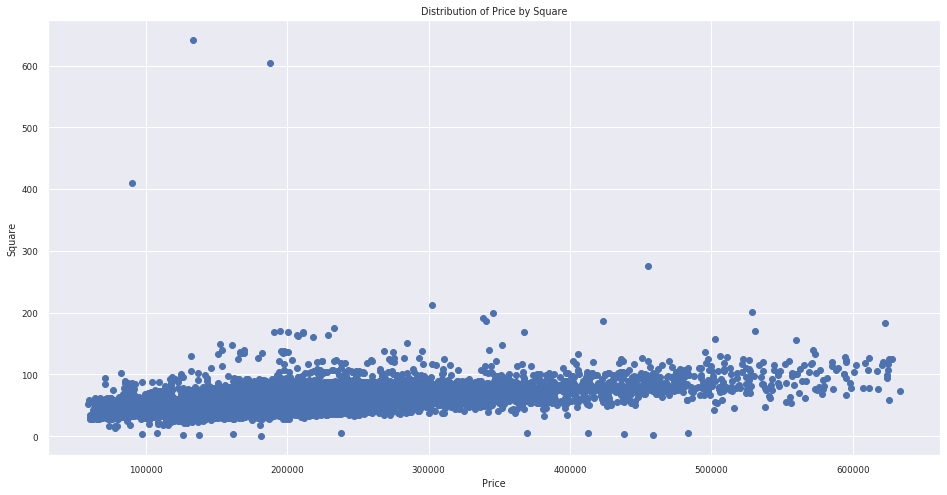

In [2371]:
show_scatter_price(df, field)

In [2372]:
df.sort_values([field], ascending=False)[field].head()

6977    641.065193
4262    604.705972
4690    409.425181
1982    275.645284
1981    212.932361
Name: Square, dtype: float64

In [2373]:
df.sort_values([field], ascending=True)[field].head()

6392    1.136859
8283    1.988943
4853    2.377248
1608    2.596351
9294    2.954309
Name: Square, dtype: float64

Квартиры с площадью более 300 кв.м. очень мало вероятно - корректируем их

In [2374]:
df_true = df[field]<300
df_false = df[field]>=300

med, mod = get_median_mode(df[df_true], field)

gr = get_district_median(df[df_true], field)
list(gr.items())[:10]

median = 52.50578046507572, mode = 1.1368587776514651


[('0', 48.99879231537124),
 ('1', 60.13927086198824),
 ('10', 49.84400549595505),
 ('100', 47.994454231859685),
 ('101', 46.41638144536218),
 ('102', 53.607639929103115),
 ('103', 52.79955635369175),
 ('104', 61.690767974960536),
 ('105', 46.15695274136199),
 ('106', 69.05341614326123)]

In [2375]:
df.loc[df_false, field] = df.loc[df_false, ['DistrictId', field]].apply(
    lambda x: [x['DistrictId'], gr.get(x['DistrictId'], med)], axis=1, result_type='broadcast')[field]

df_true = df_test[field]<300
df_false = df_test[field]>=300

df_test.loc[df_false, field] = df_test.loc[df_false, ['DistrictId', field]].apply(
    lambda x: [x['DistrictId'], gr.get(x['DistrictId'], med)], axis=1, result_type='broadcast')[field]

df[field] = df[field].astype(float)
df_test[field] = df_test[field].astype(float)

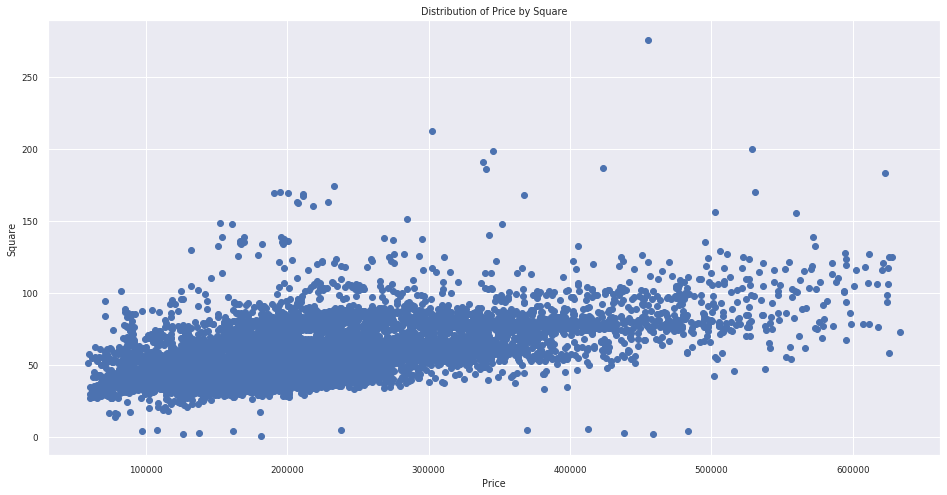

In [2376]:
show_scatter_price(df, field)

#### KitchenSquare

In [2377]:
field = 'KitchenSquare'

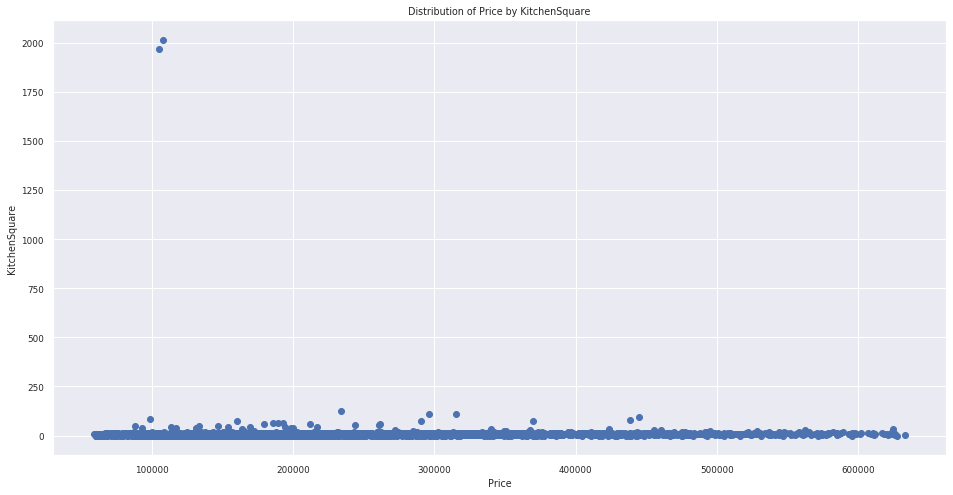

In [2378]:
show_scatter_price(df, field)

In [2379]:
df.sort_values([field], ascending=False)[field].head()

1064    2014.0
8584    1970.0
9895     123.0
2969     112.0
4651     112.0
Name: KitchenSquare, dtype: float64

In [2380]:
df.sort_values([field], ascending=True)[field].head()

8227    0.0
3302    0.0
9098    0.0
760     0.0
8192    0.0
Name: KitchenSquare, dtype: float64

In [2381]:
df_true = df[field]<200
df_false = df[field]>=200

med, mod = get_median_mode(df[df_true], field)

gr = get_district_median(df[df_true], field)
list(gr.items())[:10]

median = 6.0, mode = 1.0


[('0', 7.5),
 ('1', 1.0),
 ('10', 7.0),
 ('100', 7.0),
 ('101', 6.0),
 ('102', 7.0),
 ('103', 7.0),
 ('104', 6.0),
 ('105', 6.0),
 ('106', 10.0)]

In [2382]:
df.loc[df_false, field] = df.loc[df_false, ['DistrictId', field]].apply(
    lambda x: [x['DistrictId'], gr.get(x['DistrictId'], med)], axis=1, result_type='broadcast')[field]

df_true = df_test[field]<200
df_false = df_test[field]>=200

df_test.loc[df_false, field] = df_test.loc[df_false, ['DistrictId', field]].apply(
    lambda x: [x['DistrictId'], gr.get(x['DistrictId'], med)], axis=1, result_type='broadcast')[field]

df[field] = df[field].astype(float)
df_test[field] = df_test[field].astype(float)

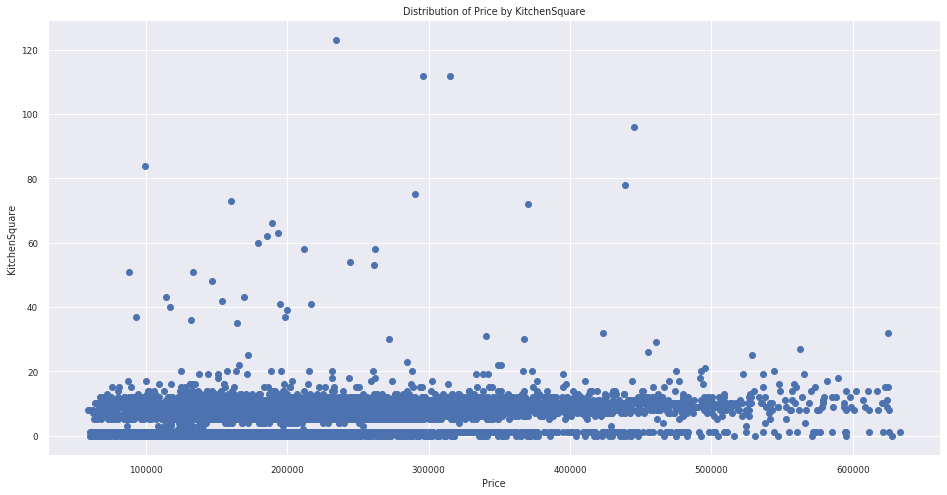

In [2383]:
show_scatter_price(df, field)

#### LifeSquare

In [2384]:
field = 'LifeSquare'

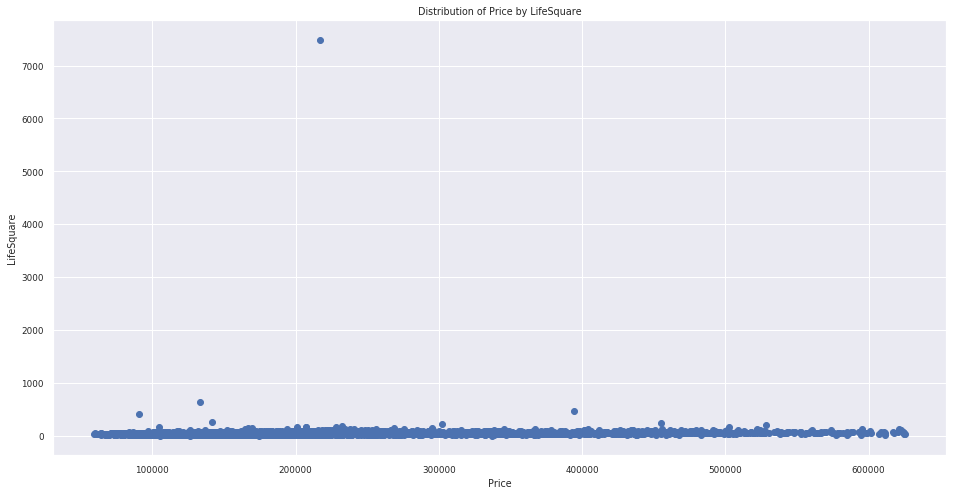

In [2385]:
show_scatter_price(df, field)

In [2386]:
df.sort_values([field], ascending=False)[field].head(10)

4328    7480.592129
6977     638.163193
8437     461.463614
4690     410.639749
590      263.542020
1982     233.949309
1981     211.231125
9910     201.627361
1641     174.837082
3651     170.713651
Name: LifeSquare, dtype: float64

In [2387]:
df.sort_values([field], ascending=True)[field].head()

6609    0.370619
26      0.641822
9602    0.795539
4853    0.873147
2887    1.049867
Name: LifeSquare, dtype: float64

In [2388]:
df_true = df[field]<250
df_false = df[field]>=250

med, mod = get_median_mode(df[df_true], field)

gr = get_district_median(df[df_true], field)
list(gr.items())[:10]

median = 32.76641712214634, mode = 0.37061941947669375


[('0', 31.40404374579359),
 ('1', 42.457421636412704),
 ('10', 32.460809440510396),
 ('100', 31.103779658355673),
 ('101', 29.16448290679205),
 ('102', 40.0555480204499),
 ('103', 30.828869575996823),
 ('104', 42.25445508590869),
 ('105', 29.33278485012932),
 ('106', 41.09991992864147)]

In [2389]:
df.loc[df_false, field] = df.loc[df_false, ['DistrictId', field]].apply(
    lambda x: [x['DistrictId'], gr.get(x['DistrictId'], med)], axis=1, result_type='broadcast')[field]

df_true = df_test[field]<250
df_false = df_test[field]>=250

df_test.loc[df_false, field] = df_test.loc[df_false, ['DistrictId', field]].apply(
    lambda x: [x['DistrictId'], gr.get(x['DistrictId'], med)], axis=1, result_type='broadcast')[field]

df[field] = df[field].astype(float)
df_test[field] = df_test[field].astype(float)

Заполним пустые значения

In [2390]:
df_true = df[field].notnull()
df_false = df[field].isnull()

med = (df.loc[df_true, 'Square'] - df.loc[df_true, 'LifeSquare'] - df.loc[df_true, 'KitchenSquare']).median()

df['SquareDiff'] = df['Square'] - df['LifeSquare'] - df['KitchenSquare']

gr = get_district_median(df[df_true], 'SquareDiff')
list(gr.items())[:10]

[('0', 12.823584448237359),
 ('1', 1.6777526369630351),
 ('10', 11.52821099148197),
 ('100', 11.789086389985648),
 ('101', 11.31804059282273),
 ('102', 8.090537534169368),
 ('103', 10.884568999936768),
 ('104', 13.328712552747874),
 ('105', 10.370392656558892),
 ('106', 18.20913093525023)]

In [2391]:
df.loc[df_false, field] = df.loc[df_false, ['DistrictId', 'Square', 'KitchenSquare', field]].apply(
    lambda x: [x['DistrictId'], x['Square'], x['KitchenSquare'], 
               x['Square'] - x['KitchenSquare'] - gr.get(x['DistrictId'], med)], 
    axis=1, result_type='broadcast')[field]

df_true = df_test[field].notnull()
df_false = df_test[field].isnull()

df_test.loc[df_false, field] = df_test.loc[df_false, ['DistrictId', 'Square', 'KitchenSquare', field]].apply(
    lambda x: [x['DistrictId'], x['Square'], x['KitchenSquare'], 
               x['Square'] - x['KitchenSquare'] - gr.get(x['DistrictId'], med)], 
    axis=1, result_type='broadcast')[field]

df[field] = df[field].astype(float)
df_test[field] = df_test[field].astype(float)

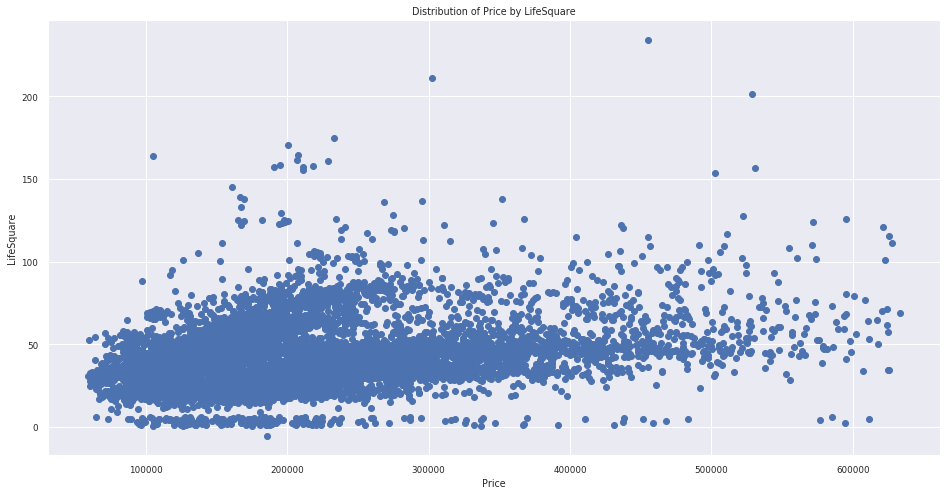

In [2392]:
show_scatter_price(df, field)

#### Square, LifeSquare, KitchenSquare

Превышение суммы жилой площади и кухни над общей площадью не будем обрабатывать

In [2393]:
df_false = df['SquareDiff'] < 0
df.loc[df_false].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,SquareDiff
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,B,23,5735,3,1084.0,0,5,B,175616.227217,-8.378531
28,8054,23,1.0,42.530043,43.967759,1.0,3,9.0,2014,0.034656,...,B,0,168,0,NaN,0,0,B,95338.198549,-2.437716
44,10521,38,3.0,104.211396,106.340403,0.0,20,0.0,2017,0.060753,...,B,15,2787,2,520.0,0,7,B,435462.048070,-2.129007
48,7596,23,1.0,47.080100,46.807989,12.0,3,9.0,1977,0.014073,...,B,2,475,0,NaN,0,0,B,96029.167877,-11.727889
52,2301,1,2.0,61.400054,65.224603,0.0,17,22.0,2016,0.007122,...,B,1,264,0,NaN,0,1,B,199215.452229,-3.824548


#### Floor

In [2394]:
field = 'Floor'

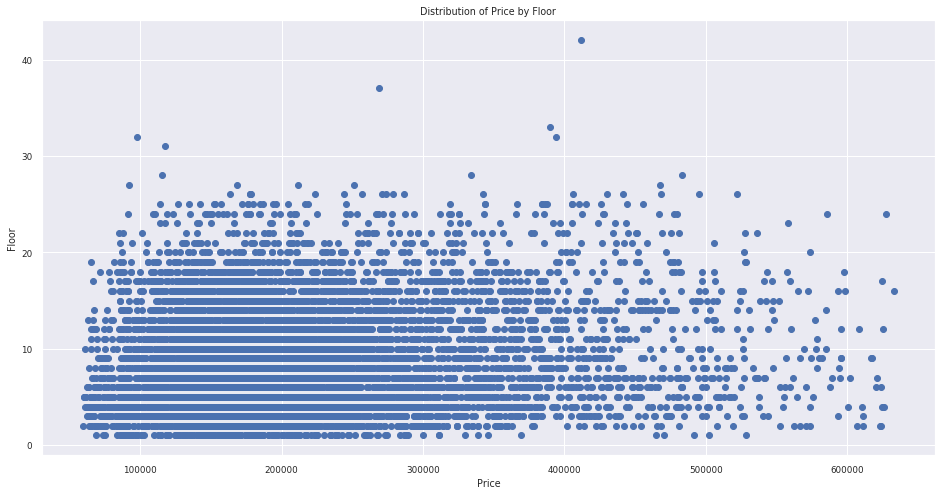

In [2395]:
show_scatter_price(df, field)

#### HouseFloor

In [2396]:
field = 'HouseFloor'

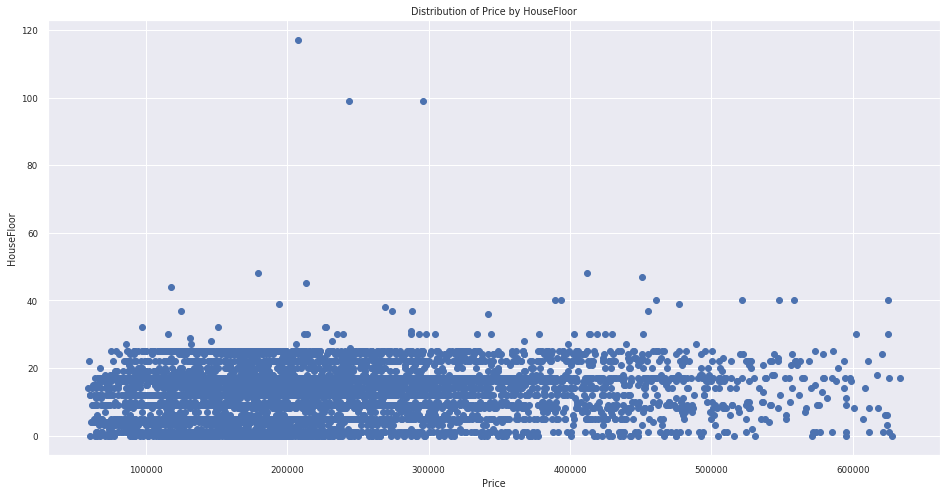

In [2397]:
show_scatter_price(df, field)

In [2398]:
df_false = df['Floor'] > df[field]
df[df_false].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,SquareDiff
7,11993,74,2.0,80.312926,72.255000,0.0,14,0.0,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,221244.156664,NaN
14,10953,27,1.0,53.769097,52.408027,1.0,5,4.0,1977,0.072158,...,B,2,629,1,NaN,0,0,A,140647.565937,0.361070
16,2119,27,2.0,49.360648,31.993964,5.0,6,5.0,1983,0.051815,...,B,5,1227,0,NaN,0,0,B,117000.381287,12.366684
21,11935,27,2.0,64.711835,54.355818,1.0,15,1.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,127200.026511,NaN
23,6641,54,3.0,118.907612,110.326754,0.0,2,0.0,1977,0.006076,...,B,30,5285,0,645.0,6,6,B,571069.052600,NaN


In [2399]:
df.loc[df_false, field] = df.loc[df_false, 'Floor']
df[df_false].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,SquareDiff
7,11993,74,2.0,80.312926,72.255000,0.0,14,14.0,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,221244.156664,NaN
14,10953,27,1.0,53.769097,52.408027,1.0,5,5.0,1977,0.072158,...,B,2,629,1,NaN,0,0,A,140647.565937,0.361070
16,2119,27,2.0,49.360648,31.993964,5.0,6,6.0,1983,0.051815,...,B,5,1227,0,NaN,0,0,B,117000.381287,12.366684
21,11935,27,2.0,64.711835,54.355818,1.0,15,15.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,127200.026511,NaN
23,6641,54,3.0,118.907612,110.326754,0.0,2,2.0,1977,0.006076,...,B,30,5285,0,645.0,6,6,B,571069.052600,NaN


In [2400]:
df_false = df_test['Floor'] > df_test[field]
df_test.loc[df_false, field] = df_test.loc[df_false, 'Floor']

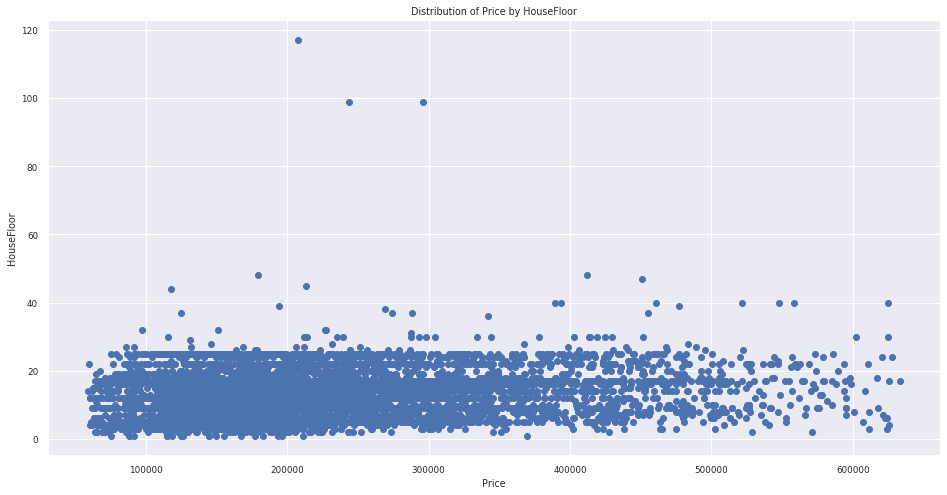

In [2401]:
show_scatter_price(df, field)

#### HouseYear

In [2402]:
field = 'HouseYear'

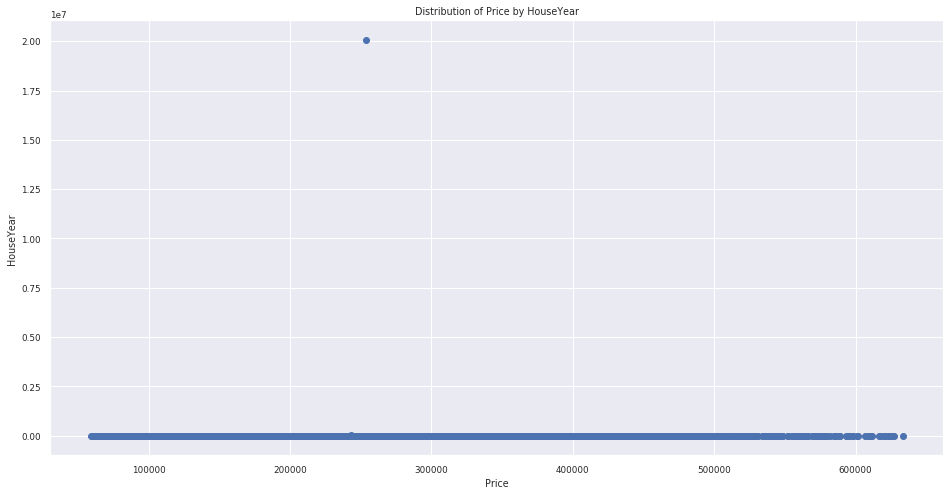

In [2403]:
show_scatter_price(df, field)

Подозрительно большое максимальное значение у параметра HouseYear

In [2404]:
df.sort_values([field], ascending=False)[field].head()

1497    20052011
4189        4968
5701        2020
2493        2020
1499        2020
Name: HouseYear, dtype: int64

In [2405]:
df.sort_values([field], ascending=True)[field].head()

9317    1910
2656    1912
5111    1912
910     1914
7611    1916
Name: HouseYear, dtype: int64

In [2406]:
df_test.sort_values([field], ascending=False)[field].head()

385     2020
888     2020
4273    2020
1275    2020
3382    2020
Name: HouseYear, dtype: int64

In [2407]:
df_test.sort_values([field], ascending=True)[field].head()

3253    1908
2       1909
2691    1910
64      1911
1475    1912
Name: HouseYear, dtype: int64

Год 2020 в принципе допустим, если это новостройки. А вот 4968 и более - это однозначно не реальные цифры

In [2408]:
med, mod = get_median_mode(df, field)

median = 1977.0, mode = 1977


Медиана и мода для года постройки оказались равны. 
Для первой строки видимо хотели написать либо 2005, либо 2011. Возьмём наиболее близкое к медиане значение - 2005.
Для второй строки скорее всего вместо 4968 хотели написать 1968. 1968 не слишком далеко находится от медианы 1977, поэтому скорректируем на 1968.

In [2409]:
df.loc[df[field]==20052011, field] = 2005

In [2410]:
df.loc[df[field]==4968, field] = 1968

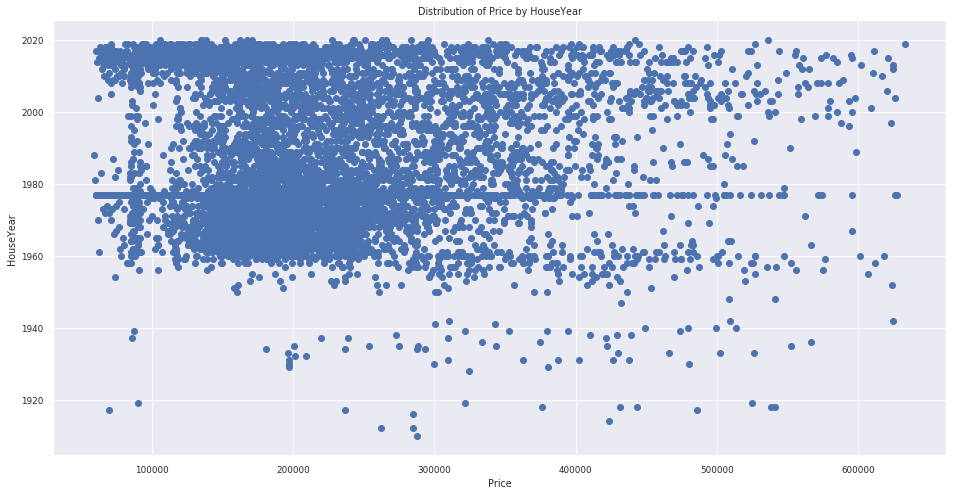

In [2411]:
show_scatter_price(df, field)

#### Ecology_1

In [2412]:
field = 'Ecology_1'

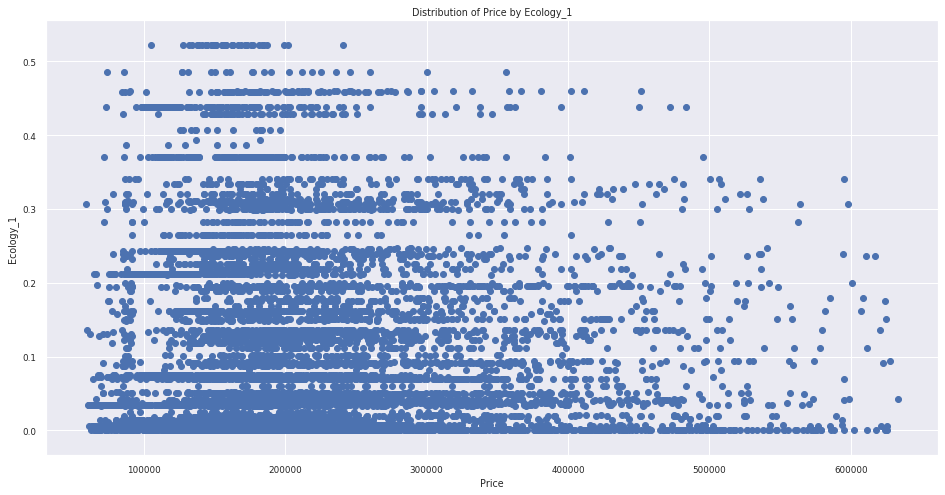

In [2413]:
show_scatter_price(df, field)

#### Social_1

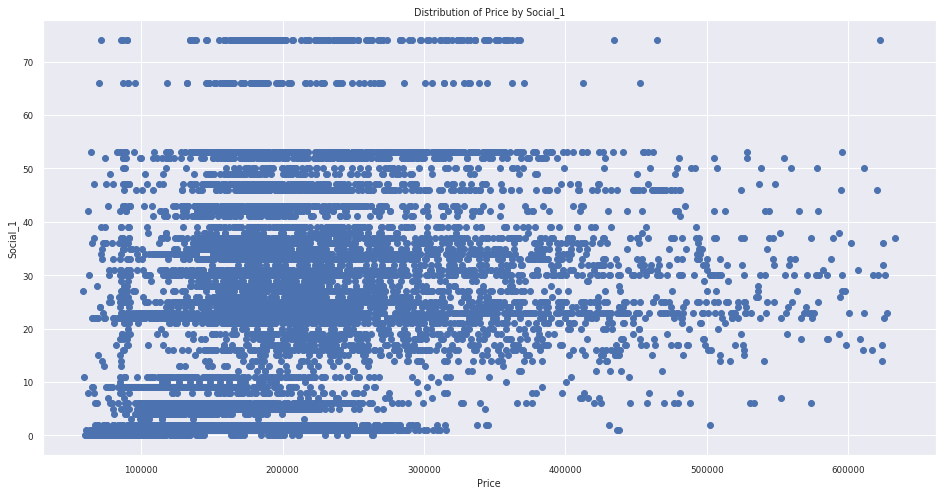

In [2414]:
field = 'Social_1'
show_scatter_price(df, field)

#### Social_2

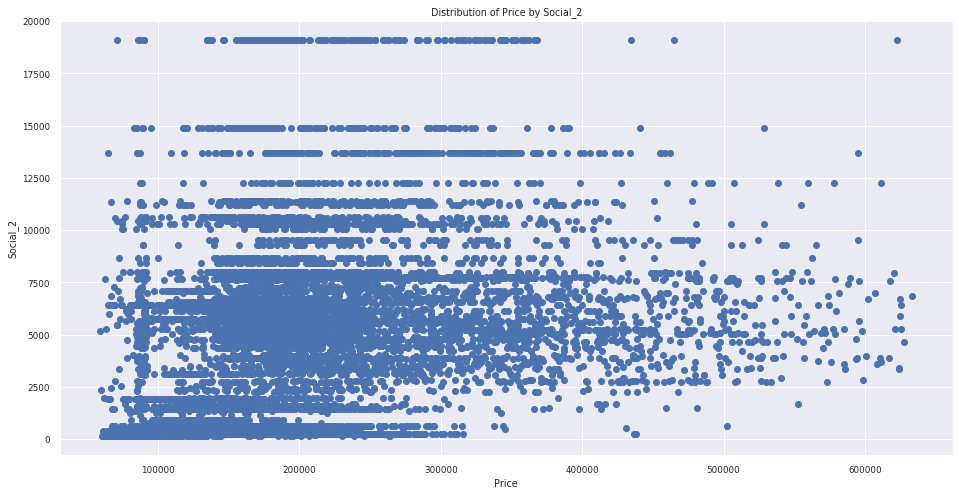

In [2415]:
field = 'Social_2'
show_scatter_price(df, field)

#### Social_3

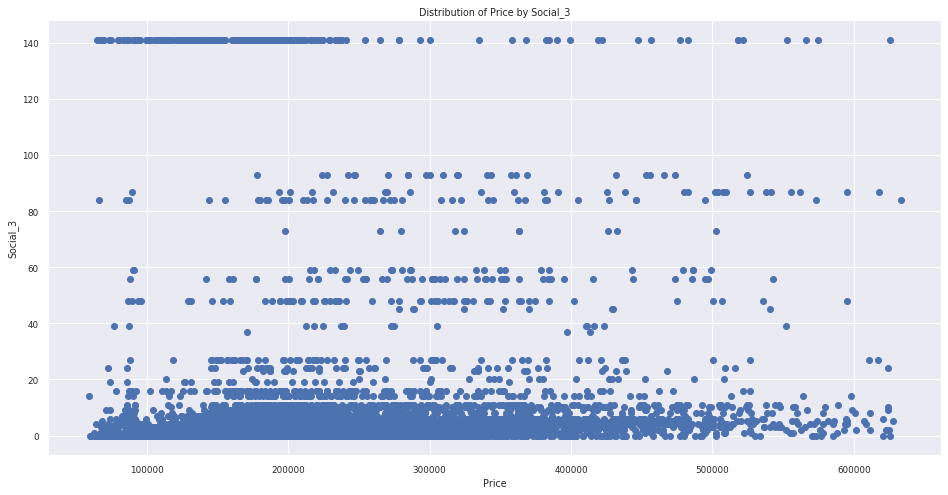

In [2416]:
field = 'Social_3'
show_scatter_price(df, field)

#### Healthcare_1

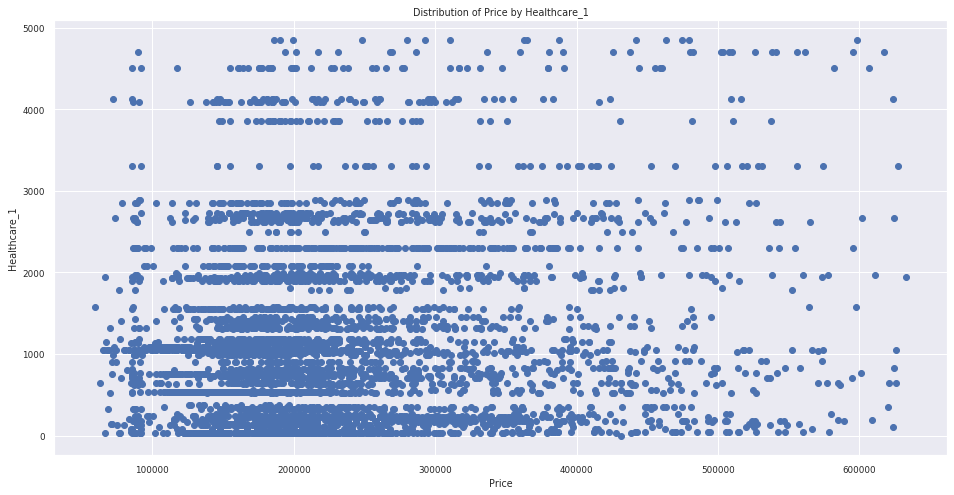

In [2417]:
field = 'Healthcare_1'
show_scatter_price(df, field)

In [2418]:
df_true = df[field].notnull()
df_false = df[field].isnull()

med, mod = get_median_mode(df[df_true], field)

gr = get_district_median(df[df_true], field)
list(gr.items())[:10]

median = 900.0, mode = 540.0


[('0', 2857.0),
 ('1', 240.0),
 ('100', 770.0),
 ('101', 1548.0),
 ('102', 705.0),
 ('103', 830.0),
 ('104', 1046.0),
 ('105', 2729.0),
 ('106', 2715.0),
 ('107', 1020.0)]

In [2419]:
df.loc[df_false, field] = df.loc[df_false, ['DistrictId', field]].apply(
    lambda x: [x['DistrictId'], gr.get(x['DistrictId'], med)], axis=1, result_type='broadcast')[field]

df_true = df_test[field].notnull()
df_false = df_test[field].isnull()

df_test.loc[df_false, field] = df_test.loc[df_false, ['DistrictId', field]].apply(
    lambda x: [x['DistrictId'], gr.get(x['DistrictId'], med)], axis=1, result_type='broadcast')[field]

df[field] = df[field].astype(float)
df_test[field] = df_test[field].astype(float)

#### Helthcare_2

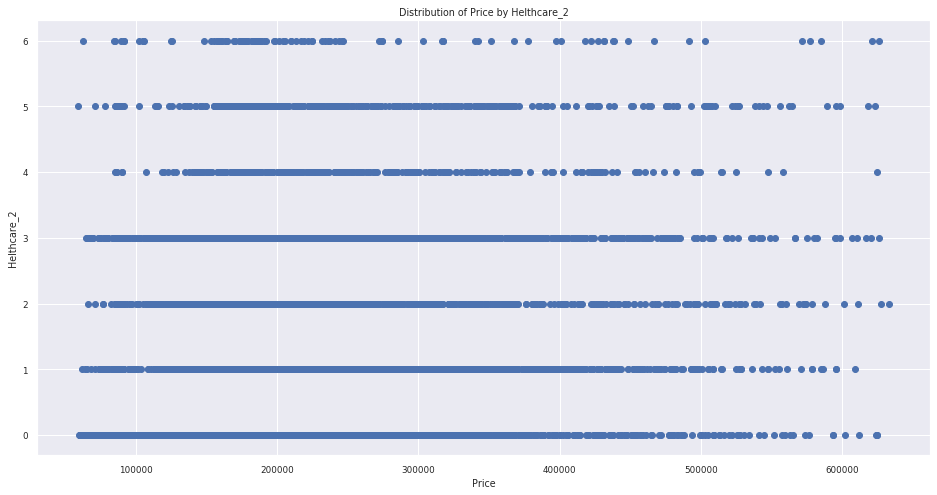

In [2420]:
field = 'Helthcare_2'
show_scatter_price(df, field)

#### Shops_1

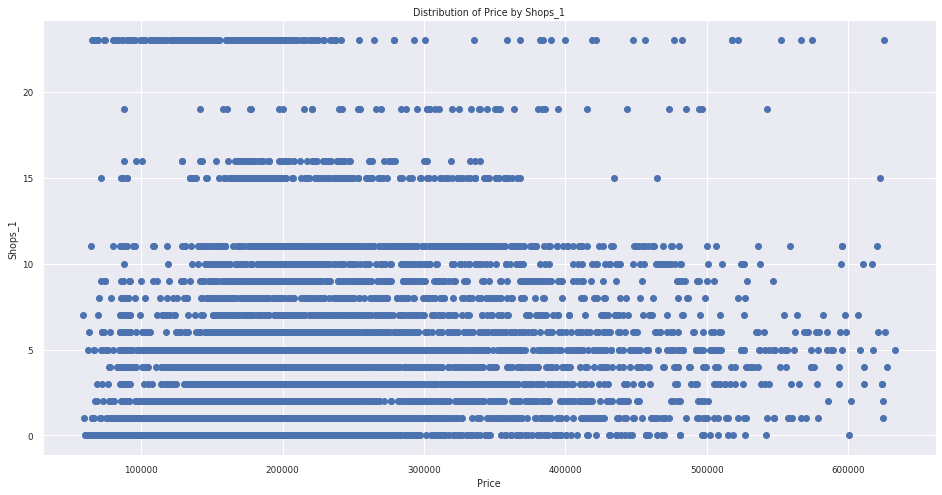

In [2421]:
field = 'Shops_1'
show_scatter_price(df, field)

### Отбор и построение новых признаков

Преобразуем категориальные признаки (Ecology_2, Ecology_3, Shops_2) в бинарные

In [2422]:
df['Ecology_2_bin'] = df['Ecology_2'].replace({'A':0, 'B':1})
df['Ecology_3_bin'] = df['Ecology_3'].replace({'A':0, 'B':1})
df['Shops_2_bin'] = df['Shops_2'].replace({'A':0, 'B':1})

df_test['Ecology_2_bin'] = df_test['Ecology_2'].replace({'A':0, 'B':1})
df_test['Ecology_3_bin'] = df_test['Ecology_3'].replace({'A':0, 'B':1})
df_test['Shops_2_bin'] = df_test['Shops_2'].replace({'A':0, 'B':1})

df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,SquareDiff,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,5,900.0,0,11,B,184966.930730,12.538811,1,1,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,240.0,1,16,B,300009.450063,17.634097,1,1,1
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,0,229.0,1,3,B,220925.908524,15.750341,1,1,1
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,3,1084.0,0,5,B,175616.227217,-8.378531,1,1,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,1,2078.0,2,4,B,150226.531644,8.873023,1,1,1


Медиана цены комнаты по кварталам

In [2423]:
med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [2424]:
df = df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,SquareDiff,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,MedPriceByDistrict
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,900.0,0,11,B,184966.930730,12.538811,1,1,1,207786.135836
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,240.0,1,16,B,300009.450063,17.634097,1,1,1,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,229.0,1,3,B,220925.908524,15.750341,1,1,1,263206.223152
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,1084.0,0,5,B,175616.227217,-8.378531,1,1,1,166809.665642
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,2078.0,2,4,B,150226.531644,8.873023,1,1,1,158539.052715


In [2425]:
df_test = df_test.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

Пустые значения для тестовой выборки заполним медианой по району, либо если и района нет, то просто медианой

In [2426]:
field = 'MedPriceByDistrict'

df_true = df[field].notnull()

med, mod = get_median_mode(df[df_true], field)

gr = get_district_median(df[df_true], field)
list(gr.items())[:10]

median = 195474.2991267647, mode = 118327.09061978915


[('0', 176210.8123341811),
 ('1', 202666.31012587005),
 ('10', 217749.6569106102),
 ('100', 234032.83622820093),
 ('101', 190884.57451377076),
 ('102', 172374.77467622785),
 ('103', 243822.51809099258),
 ('104', 367838.06020842947),
 ('105', 197311.79060293056),
 ('106', 276483.0654791653)]

In [2427]:
df_false = df_test[field].isnull()

df_test.loc[df_false, field] = df_test.loc[df_false, ['DistrictId', field]].apply(
    lambda x: [x['DistrictId'], gr.get(x['DistrictId'], med)], axis=1, result_type='broadcast')[field]

df[field] = df[field].astype(float)
df_test[field] = df_test[field].astype(float)

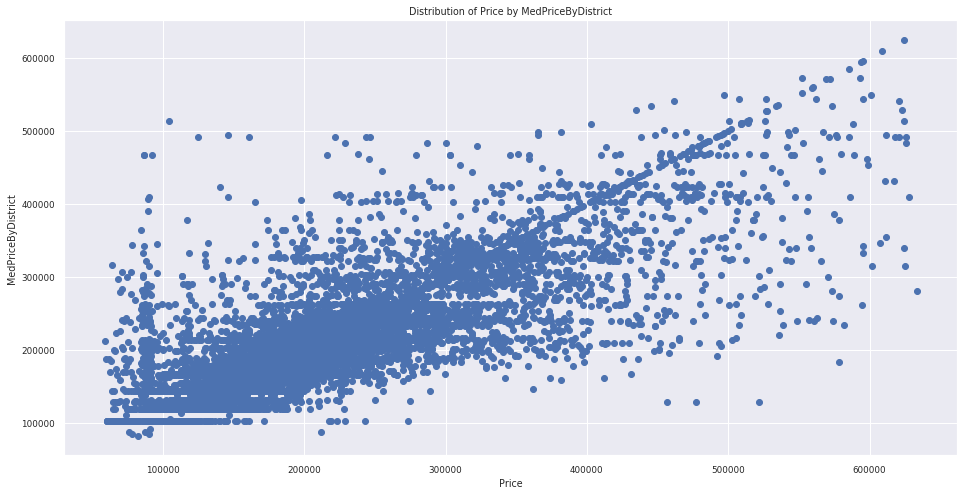

In [2428]:
show_scatter_price(df, field)

Медиана цены 1 метра с группировкой

In [2429]:
df['PriceBySquare'] = df['Price'] / df['Square']

In [2430]:
med_price_by_square_district = df.groupby(['DistrictId', 'Rooms', 'HouseYear', 'Shops_2_bin'], as_index=False).\
    agg({'PriceBySquare':'median'}).rename(columns={'PriceBySquare':'MedPriceBySquareDistrict'})

med_price_by_square_district.head()

,DistrictId,Rooms,HouseYear,Shops_2_bin,MedPriceBySquareDistrict
0,0,1.0,1961,1,4705.140719
1,0,1.0,1962,1,5097.042226
2,0,1.0,1963,1,4072.565322
3,0,1.0,1964,1,4239.744477
4,0,1.0,1965,1,5021.109740


In [2431]:
df = df.merge(med_price_by_square_district, on=['DistrictId', 'Rooms', 'HouseYear', 'Shops_2_bin'], 
              how='left')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,SquareDiff,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,MedPriceByDistrict,PriceBySquare,MedPriceBySquareDistrict
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,11,B,184966.930730,12.538811,1,1,1,207786.135836,3854.958571,4168.353315
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,16,B,300009.450063,17.634097,1,1,1,300009.450063,4567.491245,4567.491245
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,3,B,220925.908524,15.750341,1,1,1,263206.223152,4915.149522,4210.940513
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,5,B,175616.227217,-8.378531,1,1,1,166809.665642,3291.591637,2514.901904
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,4,B,150226.531644,8.873023,1,1,1,158539.052715,3788.892642,3947.468486


In [2432]:
df_test = df_test.merge(med_price_by_square_district, on=['DistrictId', 'Rooms', 'HouseYear', 'Shops_2_bin'], 
                        how='left')

Пустые значения для тестовой выборки заполним медианой по району, либо если и района нет, то просто медианой

In [2433]:
field = 'MedPriceBySquareDistrict'

df_true = df[field].notnull()

med, mod = get_median_mode(df[df_true], field)

gr = get_district_median(df[df_true], field)
list(gr.items())[:10]

median = 3915.453209341983, mode = 3194.443841925462


[('0', 3847.8943524518345),
 ('1', 3194.443841925462),
 ('10', 4452.989113146196),
 ('100', 4974.030152174977),
 ('101', 4218.592188504383),
 ('102', 2846.7087624227042),
 ('103', 4953.811526267013),
 ('104', 6176.483333786494),
 ('105', 4463.575544606245),
 ('106', 4133.740853797208)]

In [2434]:
df_false = df_test[field].isnull()

df_test.loc[df_false, field] = df_test.loc[df_false, ['DistrictId', field]].apply(
    lambda x: [x['DistrictId'], gr.get(x['DistrictId'], med)], axis=1, result_type='broadcast')[field]

df[field] = df[field].astype(float)
df_test[field] = df_test[field].astype(float)

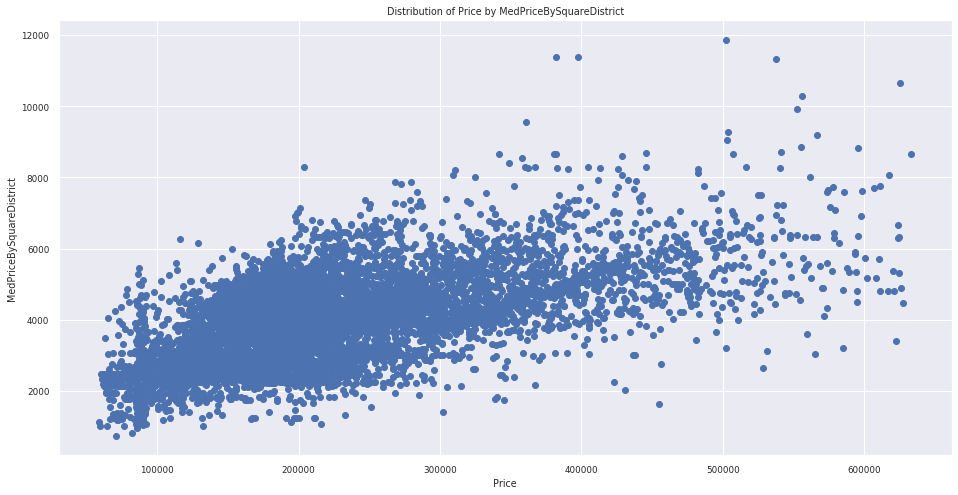

In [2435]:
show_scatter_price(df, field)

In [2436]:
df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'SquareDiff',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'MedPriceByDistrict',
 'PriceBySquare',
 'MedPriceBySquareDistrict']

In [2437]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin', 
                 'MedPriceByDistrict'#, 'MedPriceBySquareDistrict'
                ]

target_name = 'Price'

all_features = feature_names + [target_name]

### Визуализация признаков

In [2438]:
#sns.pairplot(df[all_features])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc0332f0080>,
      dtype=object)

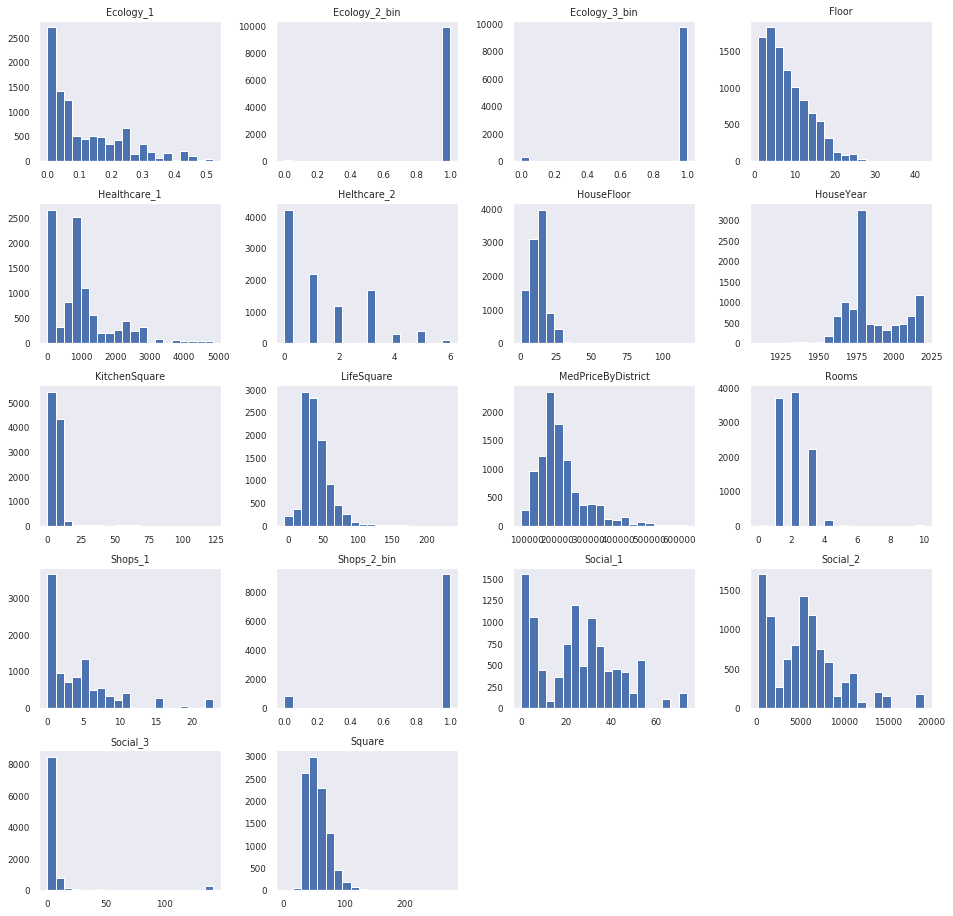

In [2439]:
df[feature_names].hist(figsize=(16,16), bins=20, grid=False)

### Матрица корреляций

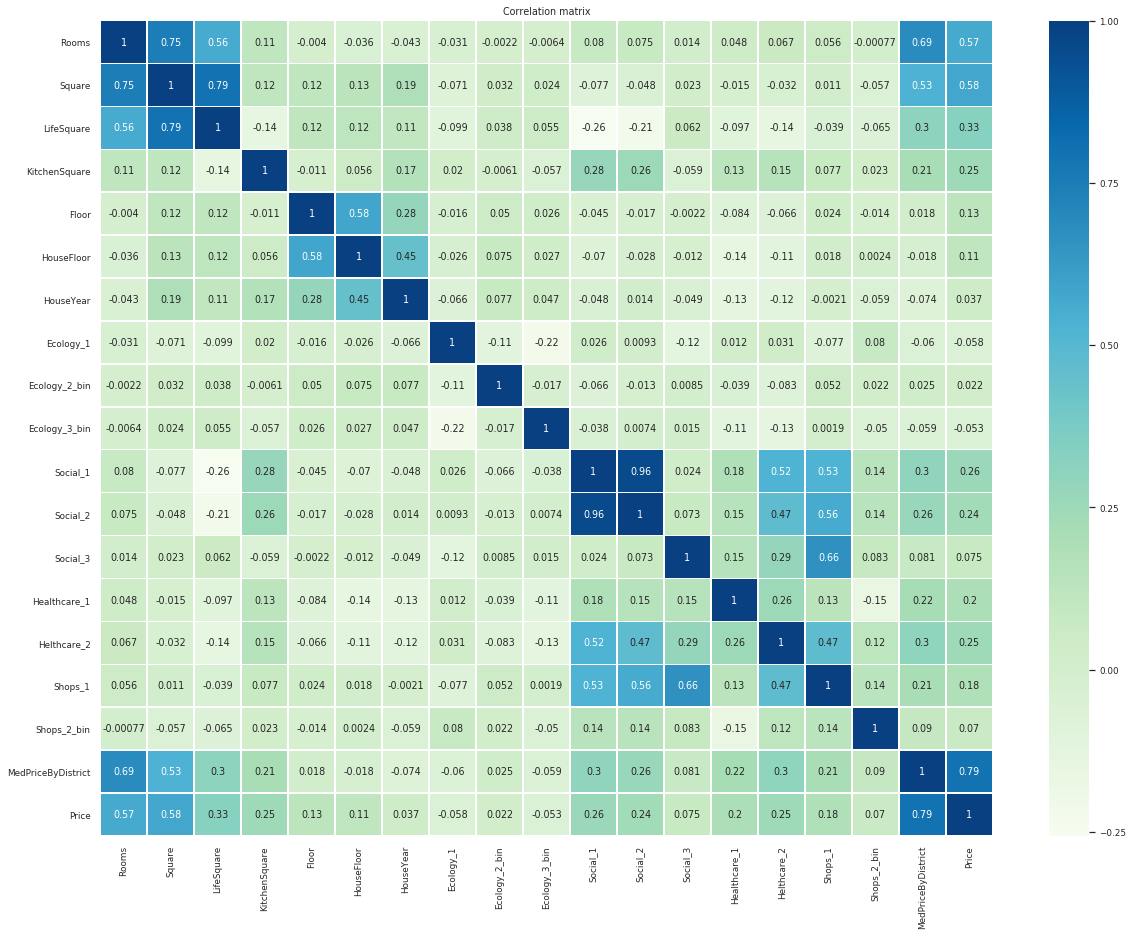

In [2440]:
plt.figure(figsize = (20,15))

sns.set(font_scale=0.8)
sns.heatmap(df[all_features].corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

## Обучение с учителем

In [2441]:
X = df[feature_names]
y = df[target_name]

In [2442]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [2443]:
gb_model = GradientBoostingRegressor(random_state=21)

params = {'n_estimators': [200, 250, 300, 350, 400, 500],
          'max_depth': [3, 4, 5, 6, 7],
          'learning_rate': [0.01, 0.05, 0.1, 0.2, 1]}

gs = GridSearchCV(gb_model, params, scoring='r2', cv=KFold(n_splits=3, random_state=21, shuffle=True), n_jobs=-1)
gs.fit(X_train, y_train)
gs.best_score_

0.7402172062844757

In [2444]:
gs.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=21, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Train R2:	0.873
Test R2:	0.785


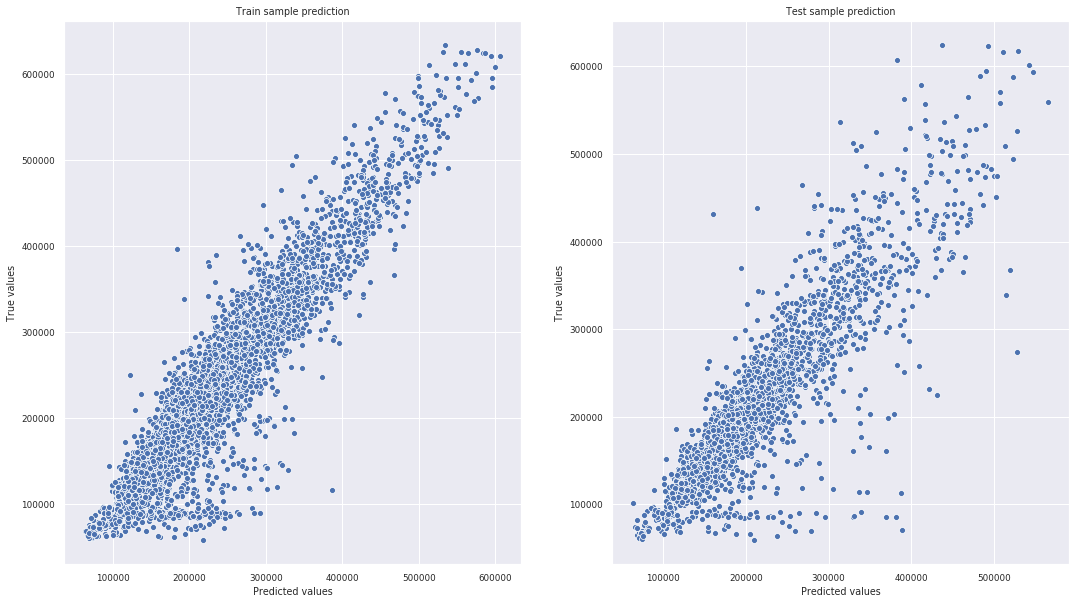

In [2445]:
y_train_preds = gs.best_estimator_.predict(X_train)
y_test_preds = gs.best_estimator_.predict(X_test)
evaluate_preds2(y_train, y_train_preds, y_test, y_test_preds)

## Предскажем цены для тестовой выборки и запишем результаты в файл

In [2447]:
y_pred = gs.best_estimator_.predict(df_test[feature_names])
result = pd.DataFrame({ 'Id': df_test['Id'], 'Price': y_pred })
result.head()

,Id,Price
0,725,162541.672924
1,15856,245480.183143
2,5480,438506.790139
3,15664,319047.257950
4,14275,135444.357729


In [2448]:
result.to_csv('RSemenov_predictions.csv', sep=',', index=False, encoding='utf-8')